Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_Study/SkinCancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI_Study/SkinCancer/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
# Load training dataset from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Directory path of the training dataset
    seed=123,  # Random seed for shuffling the dataset
    validation_split=0.2,  # Percentage of data to use for validation
    subset='training',  # Subset of the dataset to load (training set)
    label_mode='categorical',  # Type of labels to generate
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=batch_size  # Number of samples per batch
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Load validation dataset from directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Directory path of the training dataset
    seed=123,  # Random seed for shuffling the dataset
    validation_split=0.2,  # Percentage of data to use for validation
    subset='validation',  # Subset of the dataset to load (validation set)
    label_mode='categorical',  # Type of labels to generate
    image_size=(img_height, img_width),  # Target size for resizing images
    batch_size=batch_size  # Number of samples per batch
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

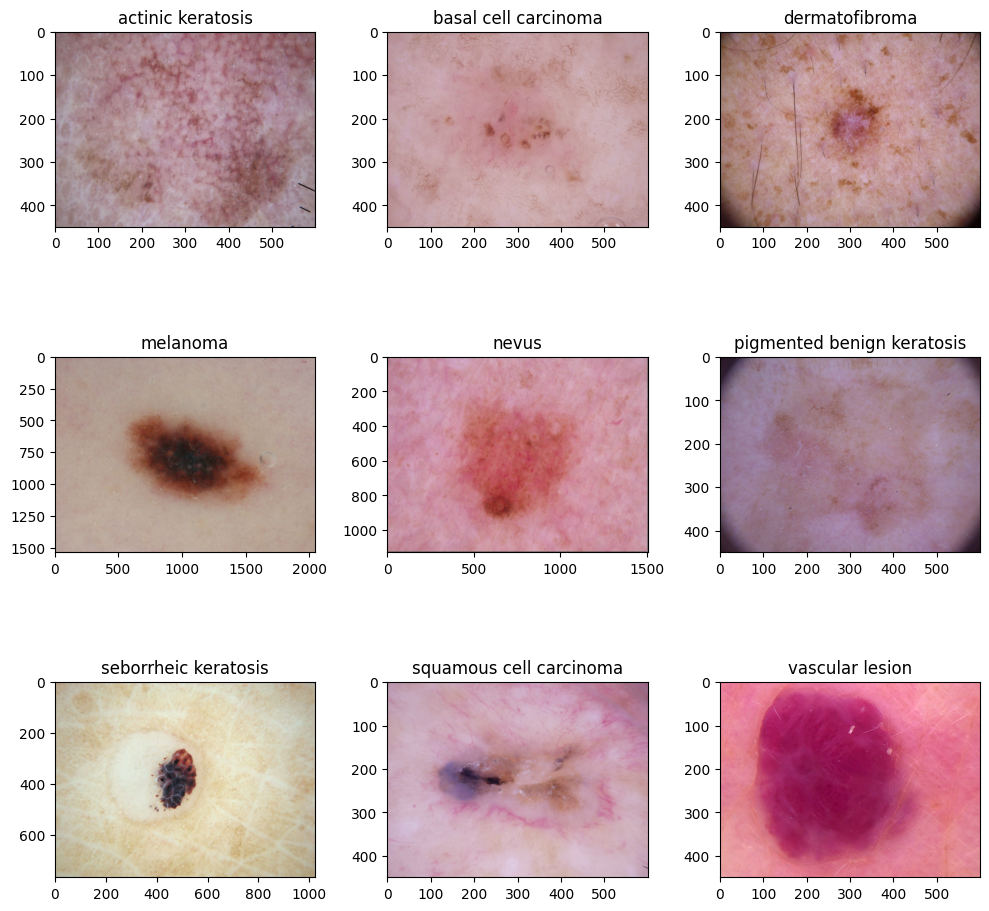

In [10]:
import matplotlib.pyplot as plt

# Create a figure with a size of 10x10 inches
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the first 9 classes
for i, ax in enumerate(axes.flat):
    # Get the path of the second image in the directory corresponding to the current class
    image_path = str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1])

    # Read and load the image
    image = plt.imread(image_path)

    # Set the title of the subplot as the class name
    ax.set_title(class_names[i])

    # Display the image
    ax.imshow(image)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# CNN model building
model = Sequential([
    # Rescaling layer
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Convolutional layers
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Dropout layer
    layers.Dropout(0.5),

    # Flatten layer
    layers.Flatten(),

    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 407s 2s/step - loss: 1.9810 - accuracy: 0.2723 - val_loss: 1.9365 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7333 - accuracy: 0.3817 - val_loss: 1.6452 - val_accuracy: 0.3915
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5987 - accuracy: 0.4302 - val_loss: 1.5094 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5299 - accuracy: 0.4704 - val_loss: 1.5023 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4421 - accuracy: 0.4967 - val_loss: 1.4564 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3838 - accuracy: 0.5128 - val_loss: 1.4081 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3726 - accuracy: 0.5229 - val_loss: 1.4858 - val_accuracy: 0.4877
Epoch 8/20
56

### Visualizing training results

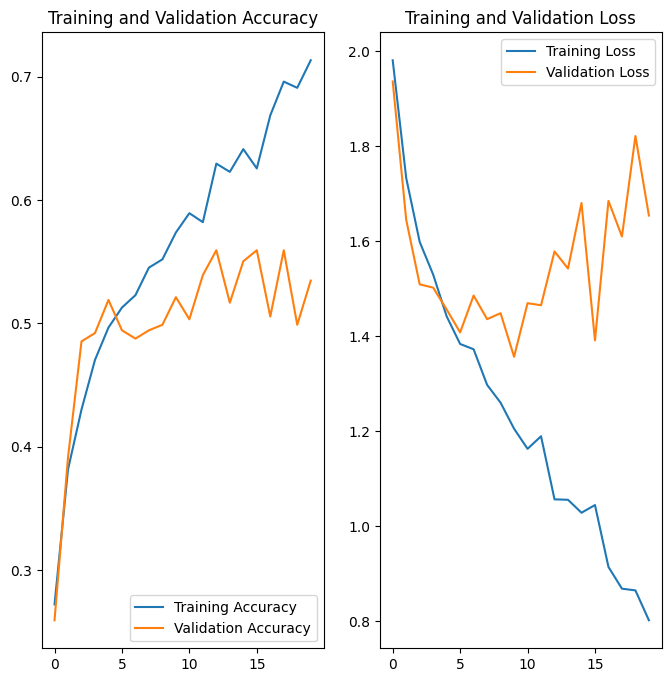

In [16]:
# Get accuracy values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get loss values from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the range of epochs
epochs_range = range(epochs)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plot
plt.show()


### The model is showing signs of overfitting because there is a discernible difference between the loss functions observed during training and testing, particularly around the 10-11th epoch.

###In terms of accuracy, the model is performing at around 75-80%. This level of accuracy suggests that the model has enough features or information to accurately remember the patterns present in the training data. However, it is important to note that accuracy alone does not provide a comprehensive assessment of model performance.

###Despite these observations, it is essential to exercise caution and refrain from making definitive conclusions regarding the overfitting and underfitting debate at this stage.
###To make a conclusive determination about whether the model is overfitting or underfitting, it is necessary to analyze further.

####The following code defines a data augmentation pipeline using Keras' Sequential model and the augmentor library. The pipeline includes three data augmentation techniques: random flip, random rotation, and random zoom.

In [17]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",
                                                input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3),
                                                width_factor=(0.2, 0.3),
                                                fill_mode='reflect')
])


#### By applying these data augmentation techniques, we can increase the diversity of the training data. Random flip allows for horizontal and vertical flipping of the images, random rotation introduces random rotations up to 0.2 radians, and random zoom applies random zooming within the specified height and width factor range.

In [18]:
# CNN model building
model = Sequential([
    # Data augmentation layer
    data_augmentation,

    # Rescaling layer to normalize pixel values to [0, 1]
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
])

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer
# Flattens the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 30% fraction of the input units to drop
model.add(layers.Dropout(0.30))

# Dense Layer with softmax activation function
# Softmax scales numbers/logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [19]:
# Optimiser and Loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [20]:
# Training the model
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 6s 58ms/step - loss: 2.1407 - accuracy: 0.2020 - val_loss: 2.0253 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9026 - accuracy: 0.3047 - val_loss: 1.6675 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7299 - accuracy: 0.3750 - val_loss: 1.7630 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5672 - accuracy: 0.4470 - val_loss: 1.6731 - val_accuracy: 0.4004
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5792 - accuracy: 0.4503 - val_loss: 1.3976 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5126 - accuracy: 0.4637 - val_loss: 1.3530 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 3s 59ms/step - loss: 1.3956 - accuracy: 0.5050 - val_loss: 1.3752 - val_accuracy: 0.5347
Epoch 8/20
56

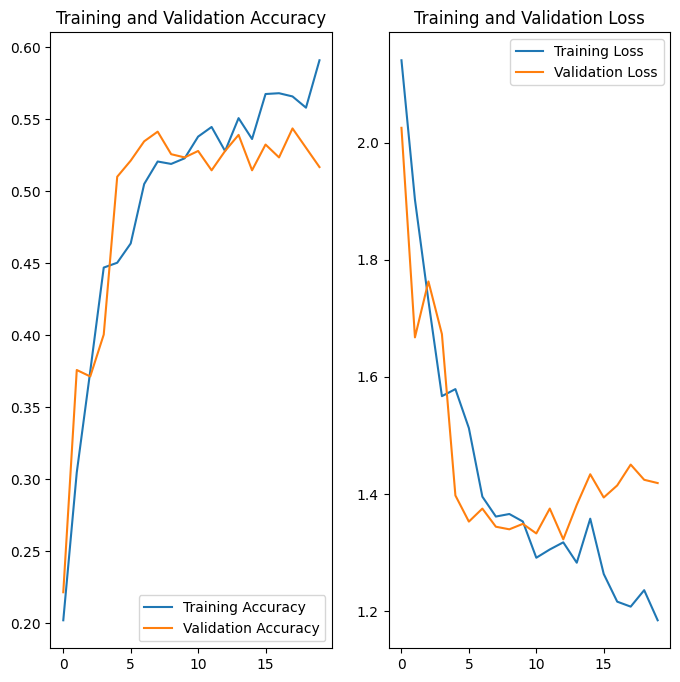

In [21]:
# Get the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Set the range of epochs
epochs_range = range(epochs)

# Create a figure with two subplots
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

# Plot the training and validation accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)

# Plot the training and validation loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plot
plt.show()


#### After analyzing the plotted results, it appears that the model's performance has improved to some extent compared to the previous model, and there is less evidence of overfitting. However, to gain a better understanding of the data, we can further explore the class distribution.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
def class_distribution_count(directory):
    """
    Count the number of images in each class within a directory.

    Args:
        directory (str): Path to the directory containing class subdirectories.

    Returns:
        pd.DataFrame: Dataframe with the class names and corresponding image counts.
    """

    count = []  # List to store image counts for each class
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            # Count the number of files in the current subdirectory (class)
            count.append(len([name for name in os.listdir(path)
                              if os.path.isfile(os.path.join(path, name))]))

    # Get the names of the classes (subdirectories)
    sub_directory = [name for name in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, name))]

    # Create a dataframe with class names and image counts
    df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

    return df

# Call the function with the specified directory
df = class_distribution_count(data_dir_train)

# Display the resulting dataframe
df


,Class,No. of Image
0,seborrheic keratosis,77
1,pigmented benign keratosis,462
2,squamous cell carcinoma,181
3,dermatofibroma,95
4,actinic keratosis,114
5,basal cell carcinoma,376
6,vascular lesion,139
7,melanoma,438
8,nevus,357


<Axes: xlabel='No. of Image', ylabel='Class'>

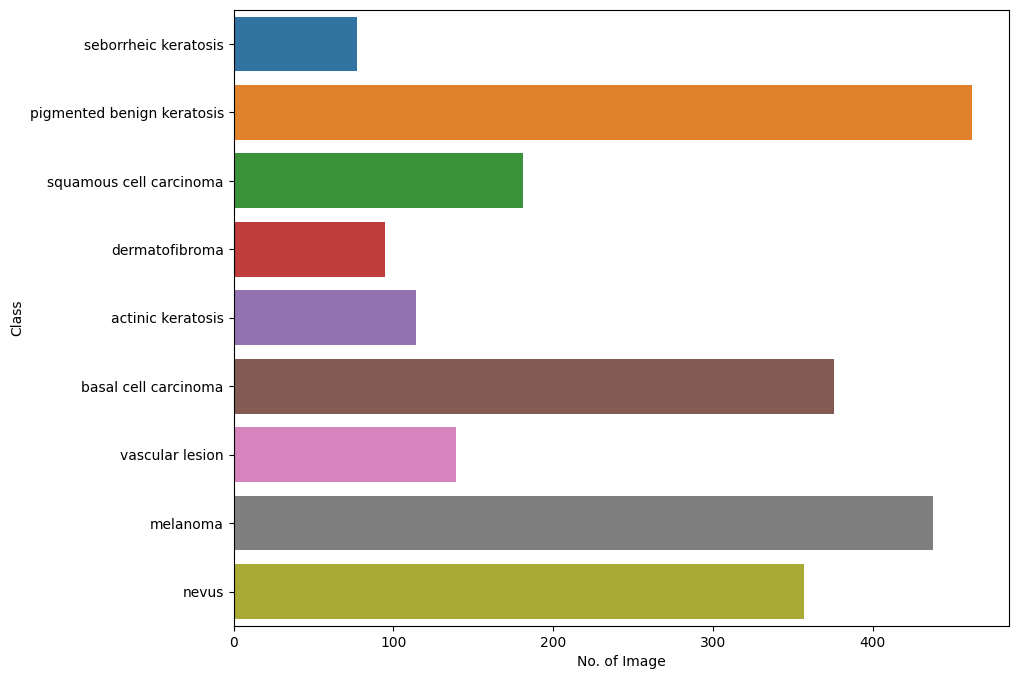

In [23]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### In the dataset, there are 462 images of pigmented benign keratosis and only 77 images of seborrheic keratosis. This indicates a class imbalance issue.

####Before proceeding further, it is important to address this class imbalance. To tackle this, I am using the augmentor library for implementing class imbalance handling techniques.


In [24]:
!pip install Augmentor
!pip install pathlib

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir_train = "/content/gdrive/MyDrive/AI_Study/SkinCancer/Train"

import Augmentor
import os


data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_Study/SkinCancer/Train")

for i in class_names:
    path = pathlib.Path(data_dir_train) / pathlib.Path(i)
    if not os.path.exists(path):
        os.mkdir(path)

    p = Augmentor.Pipeline(path, output_directory='/content/gdrive/MyDrive/AI_Study/Model/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDC3C21F160>: 100%|██████████| 500/500 [00:28<00:00, 17.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDC3C236DA0>: 100%|██████████| 500/500 [00:30<00:00, 16.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDCF2FDAF20>: 100%|██████████| 500/500 [00:23<00:00, 20.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7FDC3D2C2E60>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDC3C2A3160>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDCD23C9BD0>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDC3C200EB0>: 100%|██████████| 500/500 [00:48<00:00, 10.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDC3C2A12D0>: 100%|██████████| 500/500 [00:22<00:00, 21.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_Study/Model/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDCD24E77F0>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
# Saving our final result in output_dir
output_dir = pathlib.Path('/content/gdrive/MyDrive/AI_Study/Model')
# number of images generated
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
# Create a training dataset from the given output directory.

# Create the dataset from the output directory.
train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,
    seed=123,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
train_ds_new.element_spec


Found 4500 files belonging to 9 classes.
Using 3600 files for training.


(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [28]:
# Create a validation dataset from the given output directory.

test_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,
    seed=123,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
test_ds_new.element_spec

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds_new.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_new.cache().prefetch(buffer_size=AUTOTUNE)


### Create the model, compile and train the model


### Training the model

In [31]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Compiling the model

In [32]:
#optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
epochs = 30
history = model.fit(train_ds_new,validation_data=test_ds_new,epochs=epochs)

Epoch 1/30
113/113 [==============================] - 20s 156ms/step - loss: 1.8748 - accuracy: 0.2753 - val_loss: 1.6493 - val_accuracy: 0.3700
Epoch 2/30
113/113 [==============================] - 19s 165ms/step - loss: 1.5951 - accuracy: 0.3836 - val_loss: 1.6482 - val_accuracy: 0.3878
Epoch 3/30
113/113 [==============================] - 17s 148ms/step - loss: 1.4201 - accuracy: 0.4539 - val_loss: 1.5164 - val_accuracy: 0.4456
Epoch 4/30
113/113 [==============================] - 17s 148ms/step - loss: 1.2982 - accuracy: 0.5114 - val_loss: 1.2624 - val_accuracy: 0.5389
Epoch 5/30
113/113 [==============================] - 20s 168ms/step - loss: 1.1632 - accuracy: 0.5744 - val_loss: 1.2629 - val_accuracy: 0.5067
Epoch 6/30
113/113 [==============================] - 18s 151ms/step - loss: 1.0655 - accuracy: 0.6139 - val_loss: 1.1393 - val_accuracy: 0.5978
Epoch 7/30
113/113 [==============================] - 20s 168ms/step - loss: 0.9338 - accuracy: 0.6603 - val_loss: 1.0078 - val_ac

### Visualizing the results

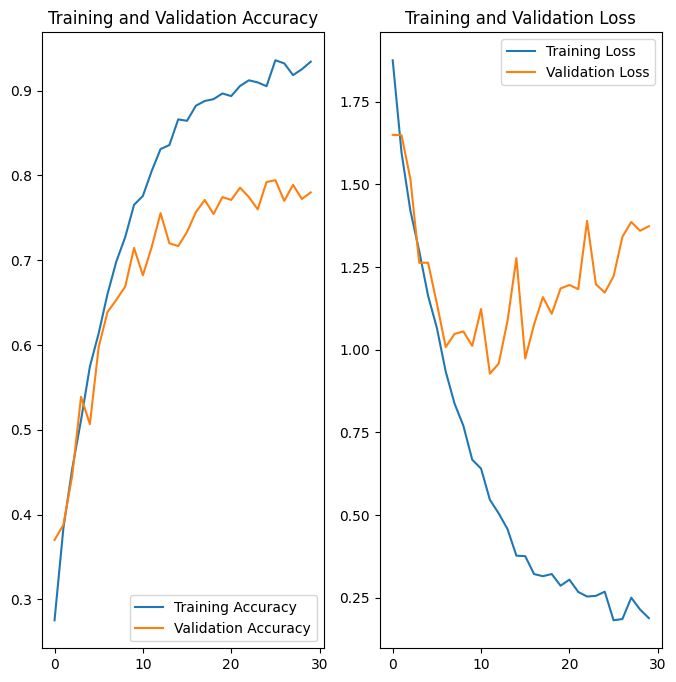

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After handling the class imbalance, the training and validation accuracy have increased. However, there is a sign of overfitting. Therefore, we may need to use other strategies to make a more accurate model.